<a href="https://colab.research.google.com/github/ArnyWu/-Preview-AI-/blob/main/week7%E4%BD%9C%E6%A5%AD_%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92ANN%E3%80%81CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>實作類神經網路模型預測股票價格

# 取得股價資料

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import yfinance as yf
import datetime as dt

In [39]:
# 輸入股票代號
stock_id = "3231.TW"  # 緯創

# 下載股票資料
stock_id = "3231.TW"
start = dt.datetime(2021, 10, 25)
end = dt.datetime(2024, 10, 25)
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')

stock_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-10-25 00:00:00+00:00,25.474052,29.200001,29.299999,29.100000,29.25,4801592
2021-10-26 00:00:00+00:00,25.561291,29.299999,29.299999,29.049999,29.25,5706678
2021-10-27 00:00:00+00:00,25.604914,29.350000,29.350000,29.100000,29.25,4920615
2021-10-28 00:00:00+00:00,25.604914,29.350000,29.400000,29.200001,29.35,4383390
2021-10-29 00:00:00+00:00,25.474052,29.200001,29.450001,29.049999,29.40,6910663
...,...,...,...,...,...,...
2024-10-18 00:00:00+00:00,109.000000,109.000000,113.000000,109.000000,112.50,37763372
2024-10-21 00:00:00+00:00,110.500000,110.500000,111.500000,109.500000,110.00,15958713
2024-10-22 00:00:00+00:00,113.000000,113.000000,113.000000,109.500000,111.00,40793829


In [40]:
# 計算 MACD 指標
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']

## 以趨勢變化作為特徵

In [41]:
# MACD 趨勢變化
stock_data['Signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
stock_data['MACD_diff'] = stock_data['MACD'] - stock_data['Signal']

stock_data

Price,Adj Close,Close,High,Low,Open,Volume,EMA_12,EMA_26,MACD,Signal,MACD_diff
Date,,,,,,,,,,,
2021-10-25 00:00:00+00:00,25.474052,29.200001,29.299999,29.100000,29.25,4801592,29.200001,29.200001,0.000000,0.000000,0.000000
2021-10-26 00:00:00+00:00,25.561291,29.299999,29.299999,29.049999,29.25,5706678,29.215385,29.207408,0.007977,0.001595,0.006382
2021-10-27 00:00:00+00:00,25.604914,29.350000,29.350000,29.100000,29.25,4920615,29.236095,29.217970,0.018125,0.004901,0.013223
2021-10-28 00:00:00+00:00,25.604914,29.350000,29.400000,29.200001,29.35,4383390,29.253619,29.227750,0.025869,0.009095,0.016774
2021-10-29 00:00:00+00:00,25.474052,29.200001,29.450001,29.049999,29.40,6910663,29.245370,29.225695,0.019675,0.011211,0.008464
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18 00:00:00+00:00,109.000000,109.000000,113.000000,109.000000,112.50,37763372,106.697292,104.309496,2.387796,1.661406,0.726390
2024-10-21 00:00:00+00:00,110.500000,110.500000,111.500000,109.500000,110.00,15958713,107.282324,104.768052,2.514272,1.831979,0.682293
2024-10-22 00:00:00+00:00,113.000000,113.000000,113.000000,109.500000,111.00,40793829,108.161967,105.377826,2.784141,2.022412,0.761729


## 計算交叉訊號特徵

In [42]:
# 檢查有無空值
print("資料中的空值數量：")
print(stock_data.isnull().sum())

資料中的空值數量：
Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
EMA_12       0
EMA_26       0
MACD         0
Signal       0
MACD_diff    0
dtype: int64


In [43]:
stock_data

Price,Adj Close,Close,High,Low,Open,Volume,EMA_12,EMA_26,MACD,Signal,MACD_diff
Date,,,,,,,,,,,
2021-10-25 00:00:00+00:00,25.474052,29.200001,29.299999,29.100000,29.25,4801592,29.200001,29.200001,0.000000,0.000000,0.000000
2021-10-26 00:00:00+00:00,25.561291,29.299999,29.299999,29.049999,29.25,5706678,29.215385,29.207408,0.007977,0.001595,0.006382
2021-10-27 00:00:00+00:00,25.604914,29.350000,29.350000,29.100000,29.25,4920615,29.236095,29.217970,0.018125,0.004901,0.013223
2021-10-28 00:00:00+00:00,25.604914,29.350000,29.400000,29.200001,29.35,4383390,29.253619,29.227750,0.025869,0.009095,0.016774
2021-10-29 00:00:00+00:00,25.474052,29.200001,29.450001,29.049999,29.40,6910663,29.245370,29.225695,0.019675,0.011211,0.008464
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18 00:00:00+00:00,109.000000,109.000000,113.000000,109.000000,112.50,37763372,106.697292,104.309496,2.387796,1.661406,0.726390
2024-10-21 00:00:00+00:00,110.500000,110.500000,111.500000,109.500000,110.00,15958713,107.282324,104.768052,2.514272,1.831979,0.682293
2024-10-22 00:00:00+00:00,113.000000,113.000000,113.000000,109.500000,111.00,40793829,108.161967,105.377826,2.784141,2.022412,0.761729


## 準備訓練資料

### 資料標準化

In [44]:
from sklearn.preprocessing import MinMaxScaler

# 保留選定的特徵
features = stock_data[['Close', 'MACD', 'Signal', 'MACD_diff']].dropna()


## 預測n日後股價

In [45]:
# 設定預測天數
N = 1  # 預測1天後的股價
target = features['Close'].shift(-N).dropna()

# 移除最後一筆資料，確保 features 和 target 長度一致
features = features[:-1]
target = target.dropna()  # 去除最後一筆 NaN 值

# 確認長度是否一致
print(f"Features length: {len(features)}, Target length: {len(target)}")

Features length: 728, Target length: 728


### 分割資料

In [46]:
# 分割資料：80% 用於訓練，20% 用於測試
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# 創建 MinMaxScaler，範圍設為 (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# 使用訓練數據擬合並標準化
X_train_scaled = scaler.fit_transform(X_train)  # 擬合並轉換訓練數據
X_test_scaled = scaler.transform(X_test)        # 僅轉換測試數據

# 如果需要對目標變數進行標準化，也可以採用相同的方式
target_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

## 模型建立

In [47]:
class StockPriceANN(nn.Module):
    def __init__(self, input_dim):
        super(StockPriceANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# 初始化模型
input_dim = X_train_scaled.shape[1]
model = StockPriceANN(input_dim)

In [48]:
# 損失函數與優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [49]:
# 將標準化後的數據轉換為 tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

In [50]:
# 訓練模型
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 0.0728
Epoch [20/300], Loss: 0.0690
Epoch [30/300], Loss: 0.0656
Epoch [40/300], Loss: 0.0623
Epoch [50/300], Loss: 0.0588
Epoch [60/300], Loss: 0.0552
Epoch [70/300], Loss: 0.0514
Epoch [80/300], Loss: 0.0475
Epoch [90/300], Loss: 0.0436
Epoch [100/300], Loss: 0.0394
Epoch [110/300], Loss: 0.0352
Epoch [120/300], Loss: 0.0308
Epoch [130/300], Loss: 0.0265
Epoch [140/300], Loss: 0.0224
Epoch [150/300], Loss: 0.0184
Epoch [160/300], Loss: 0.0145
Epoch [170/300], Loss: 0.0111
Epoch [180/300], Loss: 0.0081
Epoch [190/300], Loss: 0.0058
Epoch [200/300], Loss: 0.0040
Epoch [210/300], Loss: 0.0027
Epoch [220/300], Loss: 0.0018
Epoch [230/300], Loss: 0.0012
Epoch [240/300], Loss: 0.0008
Epoch [250/300], Loss: 0.0006
Epoch [260/300], Loss: 0.0005
Epoch [270/300], Loss: 0.0004
Epoch [280/300], Loss: 0.0004
Epoch [290/300], Loss: 0.0004
Epoch [300/300], Loss: 0.0004


In [51]:
# 預測訓練集和測試集
model.eval()
train_pred = model(X_train_tensor).detach().numpy()
test_pred = model(X_test_tensor).detach().numpy()

# 還原標準化
train_pred_rescaled = target_scaler.inverse_transform(train_pred)
test_pred_rescaled = target_scaler.inverse_transform(test_pred)
y_train_rescaled = target_scaler.inverse_transform(y_train_tensor.numpy())
y_test_rescaled = target_scaler.inverse_transform(y_test_tensor.numpy())

In [52]:
# 計算 RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.706211805343628


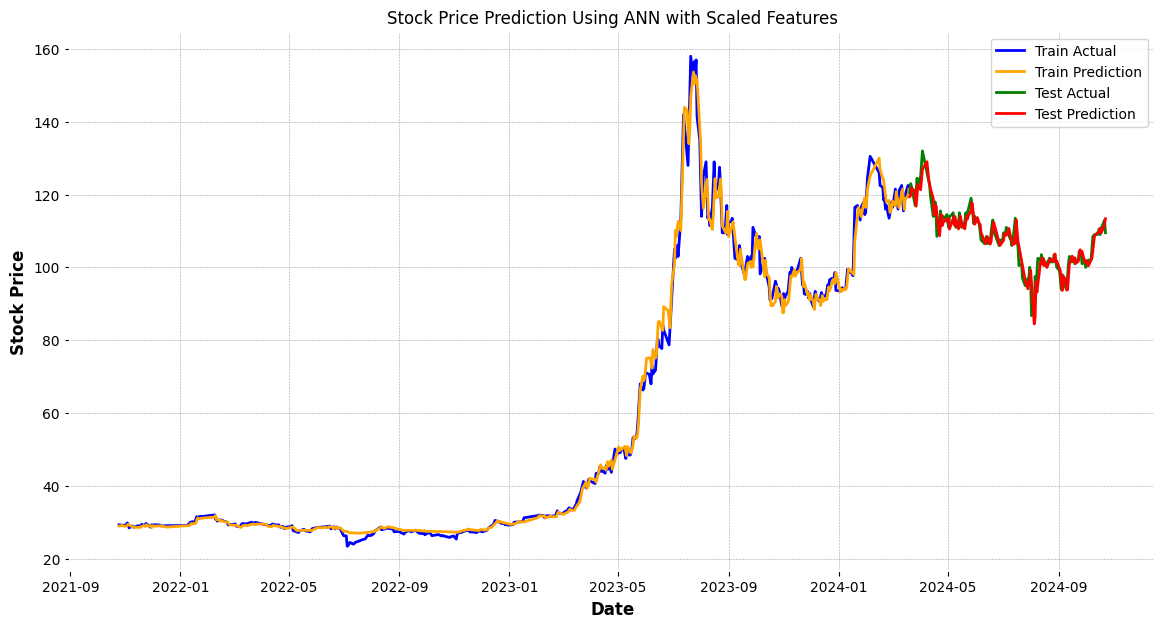

In [53]:
import matplotlib.pyplot as plt

# 可視化預測結果
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train_rescaled, label="Train Actual", color="blue")
plt.plot(y_train.index, train_pred_rescaled, label="Train Prediction", color="orange")
plt.plot(y_test.index, y_test_rescaled, label="Test Actual", color="green")
plt.plot(y_test.index, test_pred_rescaled, label="Test Prediction", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction Using ANN with Scaled Features")
plt.show()

# <b>2. 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌（分類任務）

In [2]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


使用 mplfinance 繪製帶有技術指標的 K 線圖。MACD 和移動平均線交叉可以作為標註工具。

In [1]:
import yfinance as yf
import datetime as dt
import pandas as pd

# 下載股票資料
stock_id = "3231.TW"
start = dt.datetime(2020, 10, 25)
end = dt.datetime(2024, 10, 25)
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)

# 刪除 Ticker 欄位並取代
stock_data.columns = stock_data.columns.droplevel('Ticker')

stock_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-10-26 00:00:00+00:00,23.758892,29.299999,29.650000,29.049999,29.100000,14071496
2020-10-27 00:00:00+00:00,23.515627,29.000000,29.200001,28.900000,29.100000,8080247
2020-10-28 00:00:00+00:00,23.637262,29.150000,29.650000,29.000000,29.250000,14794045
2020-10-29 00:00:00+00:00,23.272364,28.700001,28.850000,28.400000,28.799999,9734601
2020-10-30 00:00:00+00:00,23.110188,28.500000,28.799999,28.500000,28.700001,8963142
...,...,...,...,...,...,...
2024-10-18 00:00:00+00:00,109.000000,109.000000,113.000000,109.000000,112.500000,37763372
2024-10-21 00:00:00+00:00,110.500000,110.500000,111.500000,109.500000,110.000000,15958713
2024-10-22 00:00:00+00:00,113.000000,113.000000,113.000000,109.500000,111.000000,40793829


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


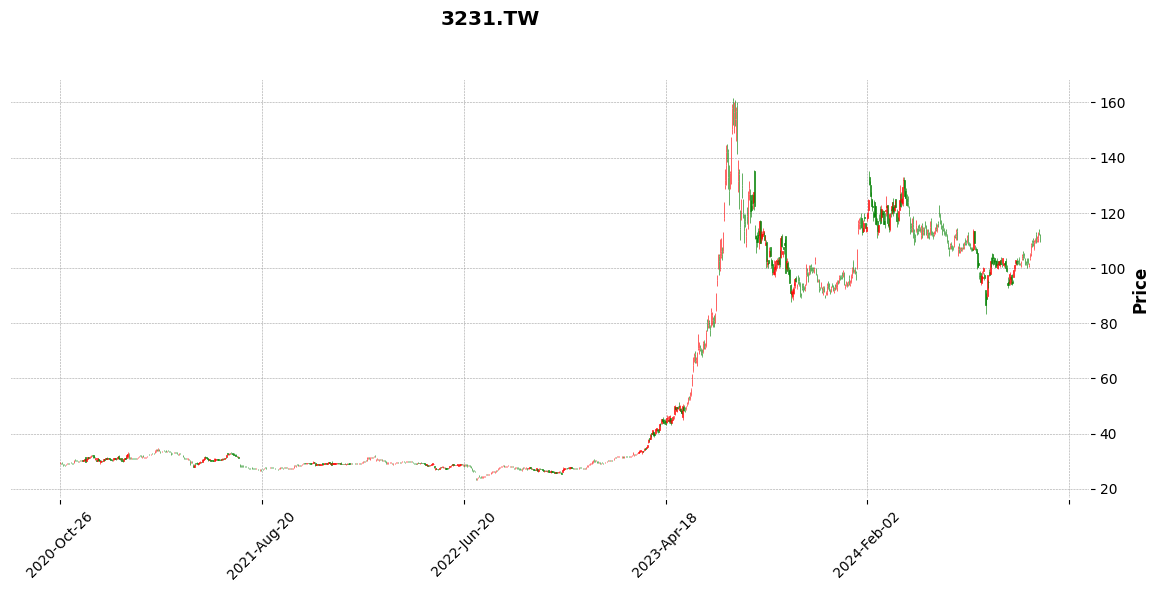

In [3]:
import mplfinance as mpf
# 設置 K 線繪圖風格，漲為紅色，跌為綠色
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='charles', marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(stock_data, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

# <b>2. 資料前處理</b>

## <b>2.1. 擷取與標記</b>

當 MACD 線上穿過訊號線時，標註為「漲」，反之則標註為「跌」，5 日均線高於 10 和 20 日均線可標註為「漲」，5 日均線低於 10 和 20 日均線則為「跌」，當兩者都標註為漲即漲，反之，若出現不同的標註，如當 ATR 高且價格向上時標註為「漲」。

In [4]:
# 計算 MACD
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['Signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

# 計算移動平均線
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()

# 計算 ATR（平均真實波動範圍）
high_low = stock_data['High'] - stock_data['Low']
high_close = abs(stock_data['High'] - stock_data['Close'].shift())
low_close = abs(stock_data['Low'] - stock_data['Close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
stock_data['ATR'] = true_range.rolling(window=14).mean()  # 使用 14 日均值

In [5]:
import numpy as np

# 設定漲跌標註根據 MACD 和 Signal
stock_data['MACD_Label'] = np.where(stock_data['MACD'] > stock_data['Signal'], 1, 0)  # 1: 上穿訊號線，標註為「漲」；0: 下穿訊號線，標註為「跌」

# 設定漲跌標註根據移動平均線
stock_data['SMA_Label'] = np.where((stock_data['SMA_5'] > stock_data['SMA_10']) & (stock_data['SMA_5'] > stock_data['SMA_20']), 1, 0)

# 設定 ATR 條件標註
# 當 ATR 大於某個臨界值且價格在 5 日均線之上時，標註為「漲」
atr_threshold = stock_data['ATR'].mean()  # 可以調整或以平均作為臨界值
stock_data['ATR_Label'] = np.where((stock_data['ATR'] > atr_threshold) & (stock_data['Close'] > stock_data['SMA_5']), 1, 0)

# 綜合標註邏輯：若 MACD_Label、SMA_Label 和 ATR_Label 都顯示「漲」則為「漲」
stock_data['Label'] = np.where(
    (stock_data['MACD_Label'] == 1) & (stock_data['SMA_Label'] == 1) & (stock_data['ATR_Label'] == 1),
    1,
    0  # 若有任一顯示「跌」，則標註為「跌」
)

In [6]:
import numpy as np
import os
# 設定時間區間與技術指標
N = 20  # 設定 N 天的 K 線
k_line_images = []
labels = []

# 創建資料夾來儲存 K 線圖像
output_dir = "kline_images"
os.makedirs(output_dir, exist_ok=True)

# 計算技術指標（移動平均線和 MACD）
stock_data["5_SMA"] = stock_data["Close"].rolling(window=5).mean()
stock_data["10_SMA"] = stock_data["Close"].rolling(window=10).mean()
stock_data["26_EMA"] = stock_data["Close"].ewm(span=26, adjust=False).mean()
stock_data["12_EMA"] = stock_data["Close"].ewm(span=12, adjust=False).mean()
stock_data["MACD"] = stock_data["12_EMA"] - stock_data["26_EMA"]
stock_data["Signal"] = stock_data["MACD"].ewm(span=9, adjust=False).mean()

# 遍歷資料並生成 K 線圖
for i in range(len(stock_data) - N):
    subset = stock_data.iloc[i:i+N]

    # 判斷上漲或下跌標註（5 日均線和 10 日均線交叉）
    label = 1 if subset["5_SMA"].iloc[-1] > subset["10_SMA"].iloc[-1] else 0
    labels.append(label)

    # 設定 K 線圖樣式
    mpf.plot(
        subset,
        type="candle",
        style=my_style,
        title=f"{stock_id} - {subset.index[0].strftime('%Y-%m-%d')} to {subset.index[-1].strftime('%Y-%m-%d')}",
        savefig=f"{output_dir}/kline_{i}.png"
    )
    k_line_images.append(f"kline_{i}.png")

# 儲存標註資料集為 CSV
label_df = pd.DataFrame({"image": k_line_images, "label": labels})
label_df.to_csv("kline_labels.csv", index=False)

自定義資料集類別

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import pandas as pd
import os
# 自定義資料集類別
class KLineDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# 轉換設定
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 轉換設定
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 加載資料
dataset = KLineDataset(csv_file="kline_labels.csv", root_dir="kline_images", transform=transform)

總共有 952 筆資料
上漲的筆數: 524
下跌的筆數: 428


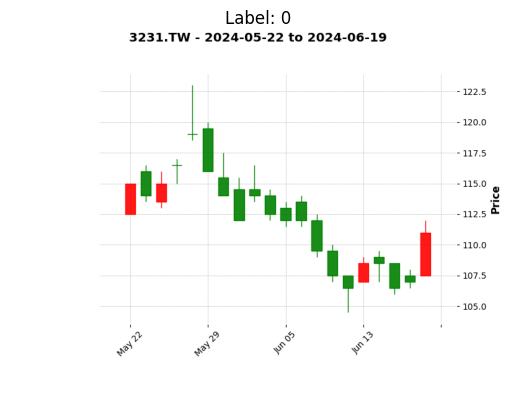

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

# 載入標註資料
label_df = pd.read_csv("kline_labels.csv")

# 顯示總資料筆數
total_count = len(label_df)
print(f"總共有 {total_count} 筆資料")

# 計算上漲和下跌的筆數
rise_count = (label_df["label"] == 1).sum()
fall_count = (label_df["label"] == 0).sum()
print(f"上漲的筆數: {rise_count}")
print(f"下跌的筆數: {fall_count}")

# 隨機選取一張圖片
random_index = random.randint(0, total_count - 1)
random_image_path = os.path.join("kline_images", label_df.iloc[random_index]["image"])

# 顯示圖片和標籤
image = Image.open(random_image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Label: {label_df.iloc[random_index]['label']}")
plt.show()

## 切割資料

In [9]:
# 將資料切分為 80% 訓練集和 20% 測試集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 建立訓練和測試的 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 建立模型

In [10]:
# 定義 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 112 * 112, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc1(x)
        return x

# 初始化模型、損失函數與優化器
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 訓練模型

In [11]:
# 訓練模型
epochs = 15
train_losses = []  # 儲存每個 epoch 的訓練損失
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 計算每個 epoch 的平均損失
    avg_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/15], Loss: 4.4304
Epoch [2/15], Loss: 0.5044
Epoch [3/15], Loss: 0.2637
Epoch [4/15], Loss: 0.1731
Epoch [5/15], Loss: 0.1291
Epoch [6/15], Loss: 0.1026
Epoch [7/15], Loss: 0.0896
Epoch [8/15], Loss: 0.1026
Epoch [9/15], Loss: 0.0850
Epoch [10/15], Loss: 0.0621
Epoch [11/15], Loss: 0.0519
Epoch [12/15], Loss: 0.0380
Epoch [13/15], Loss: 0.0273
Epoch [14/15], Loss: 0.0585
Epoch [15/15], Loss: 0.0439


## 訓練結果

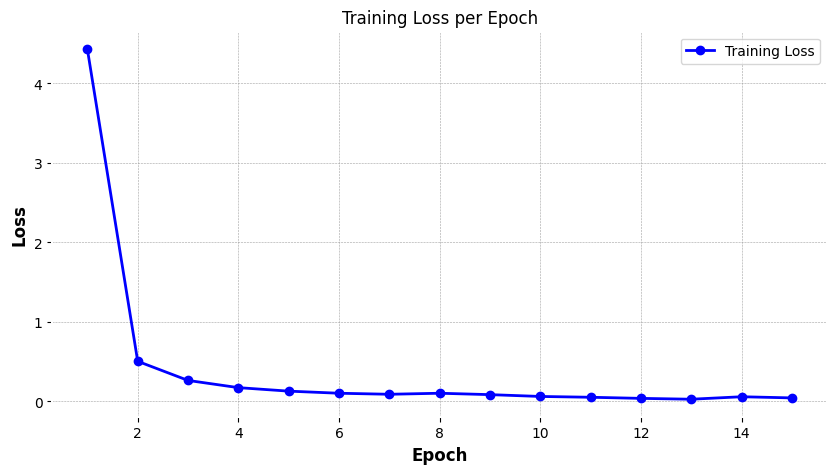

In [12]:
# 可視化訓練損失變化
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## 測試


In [13]:
# 測試模型的預測表現
# 這裡展示如何在測試資料集上評估模型
model.eval()
test_loss = 0.0
correct = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_dataloader)
accuracy = 100 * correct / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.2739, Test Accuracy: 87.43%


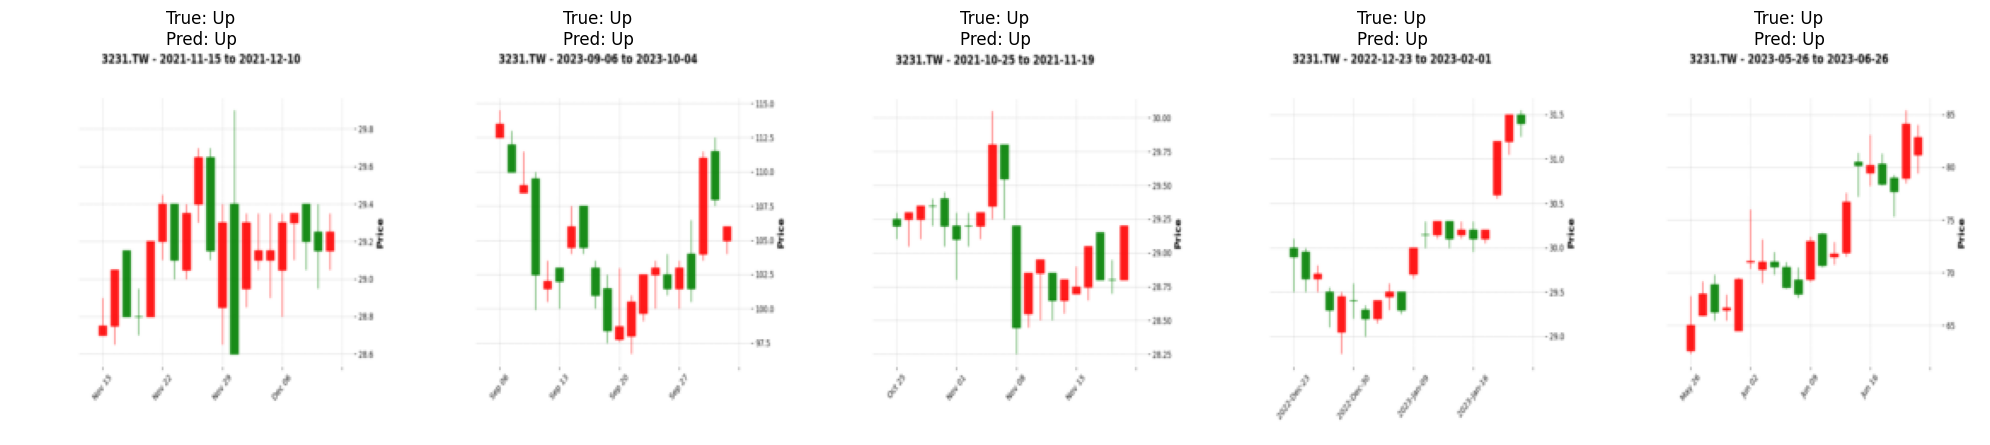

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 從測試集中選擇一些圖像來顯示模型的預測結果
model.eval()
sample_images, sample_labels = next(iter(test_dataloader))  # 從測試 dataloader 中取一批圖像

# 使用模型進行預測
with torch.no_grad():
    sample_outputs = model(sample_images)
    _, predictions = torch.max(sample_outputs, 1)

# 顯示測試圖像及預測結果
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):  # 顯示前 5 張圖像
    image = sample_images[i].permute(1, 2, 0).numpy()  # 調整圖像維度以便顯示
    label = "Up" if sample_labels[i].item() == 1 else "Down"
    pred = "Up" if predictions[i].item() == 1 else "Down"

    axes[i].imshow(image)
    axes[i].set_title(f"True: {label}\nPred: {pred}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()